# Monte Carlo simulation for Coefficient 2



In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import random
import csv

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient
from data import * 

from gridlod import interp, coef, util, fem, world, linalg, femsolver
import pg_rand, femsolverCoarse, buildcoef2d
from gridlod.world import World


## Result function

In [2]:
def result(pglod, world, CoefClass, A, f, MC=1, prob=100):
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
    
    plist = [0,5,10,20,30,100]
    
    #### initial #####
    xmLoda = np.zeros([MC,np.size(plist)])
    xmVcLoda = np.zeros([MC,np.size(plist)])
    xmLodVcLoda = np.zeros([MC,np.size(plist)])
    
    ems = []
    
    plottingx = np.zeros([MC-1,np.size(plist)])
    plottingy = np.zeros([MC-1,np.size(plist)])
    plottingz = np.zeros([MC-1,np.size(plist)])
        
    plotting2x = np.zeros([MC-1,np.size(plist)])
    plotting2y = np.zeros([MC-1,np.size(plist)])
    plotting2z = np.zeros([MC-1,np.size(plist)])
    
    plotting3x = np.zeros([MC-1,np.size(plist)])
    plotting3y = np.zeros([MC-1,np.size(plist)])
    plotting3z = np.zeros([MC-1,np.size(plist)])

    for i in range(0,MC):
        print '_____Sample__ ' + str(i+1) + '/' + str(MC) + ' ____' 
        R = CoefClass.RandomVanish( probfactor      = prob,
                                    PartlyVanish    = None,
                                    Original        = True)
        
        ANew = R.flatten()
        
        ###### Reference solution ######
        f_fine = np.ones(NpFine)
        uFineFem, AFine, MFine = femsolver.solveFine(world, ANew, f_fine, None, boundaryConditions)
        
        Anew = coef.coefficientFine(NWorldCoarse, NCoarseElement, ANew)
        
        ###### tolerance = 0 without computing ######
        vis, eps = pglod.updateCorrectors(Anew, 0, f, 1, clearFineQuantities=False, mc=True, Computing=None)
        print 'Affected correctors: ' + str(np.sum(vis))
        
        ##### VCLOD ######
        uVc = []
        updated = 0
        for p in plist:
            print 'p = ' + str(p) + '%',
            uVcLod, updated = VcLod(pglod, world, Anew, eps, updated, numberofcorrectors=p)
            if p == 100:
                uLod = uVcLod
                pglod.CorrectorsToOrigin()
            else:
                uVc.append(uVcLod)
        
        for k in range(0,np.shape(uVc)[0]):
            uVcLod = uVc[k]
            eVcLod = np.sqrt(np.dot(uFineFem - uVcLod, MFine*(uFineFem - uVcLod))) / np.sqrt(np.dot(uFineFem, MFine*uFineFem))
            eLodVcLod = np.sqrt(np.dot(uVcLod - uLod, MFine*(uVcLod - uLod))) / np.sqrt(np.dot(uLod, MFine*uLod))
            eLod = np.sqrt(np.dot(uFineFem - uLod, MFine*(uFineFem - uLod))) / np.sqrt(np.dot(uFineFem, MFine*uFineFem))
            
            xmLoda[i,k] = eLod
            xmVcLoda[i,k] = eVcLod
            xmLodVcLoda[i,k] = eLodVcLod
           
        if i == 0:
            continue
        ems.append(i+1)
        
        for k in range(0,np.shape(uVc)[0]):
            muLod = 0
            muVcLod = 0
            muLodVcLod = 0
            for j in range(0,i+1):
                muLod += xmLoda[j,k]
                muVcLod += xmVcLoda[j,k]
                muLodVcLod += xmLodVcLoda[j,k]
    
            muLod /= i+1
            muVcLod /= i+1
            muLodVcLod /= i+1
    
            sig2Lod = 0
            sig2VcLod = 0
            sig2LodVcLod = 0
    
            for j in range(0,i+1):
                sig2Lod += (xmLoda[j,k]-muLod)**(2)
                sig2VcLod += (xmVcLoda[j,k]-muVcLod)**(2)
                sig2LodVcLod += (xmLodVcLoda[j,k]-muLodVcLod)**(2)
        
            sig2Lod /= i
            sig2VcLod /= i
            sig2LodVcLod /= i
    
            a = [np.sqrt(sig2Lod)/np.sqrt(i+1)*1.96,np.sqrt(sig2VcLod)/np.sqrt(i+1)*1.96,np.sqrt(sig2LodVcLod)/np.sqrt(i+1)*1.96]
            mum = [muLod,muVcLod,muLodVcLod]
            
            plottingx[i-1,k] = mum[0]-a[0]
            plottingy[i-1,k] = mum[0]
            plottingz[i-1,k] = mum[0]+a[0]
        
            plotting2x[i-1,k] = mum[1]-a[1]
            plotting2y[i-1,k] = mum[1]
            plotting2z[i-1,k] = mum[1]+a[1]

            plotting3x[i-1,k] = mum[2]-a[2]
            plotting3y[i-1,k] = mum[2]
            plotting3z[i-1,k] = mum[2]+a[2]
            
            Matrix = CoefClass.Matrix.flatten()
            ROOT = '../test_data/MonteCarlo/Coef2/p' + str(100/prob) + '/' + str(plist[k]) 
            safer(ROOT, mum, a, plottingx[:,k], plottingy[:,k], plottingz[:,k], plotting2x[:,k], plotting2y[:,k], plotting2z[:,k], plotting3x[:,k], plotting3y[:,k], plotting3z[:,k], ems, Matrix)
        
    return a,mum

## VC-LOD

In [3]:
def VcLod(pglod, world, Anew, eps, updated = 0,
    numberofcorrectors=5):
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement

    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)

    ##### tolerance = certain ######
    eps = filter(lambda x: x!=0, eps)
    eps.sort()
    epssize = np.size(eps)
    until = int(round((numberofcorrectors/100. * epssize) +0.49,0))
    if epssize != 0:
        until = int(round((until * 256./epssize)+0.49,0))
    tolrev = []
    for i in range(epssize-1,-1,-1):
        tolrev.append(eps[i])
    
    if epssize == 0:
        print 'nothing to update'
    else:
        if until >= epssize:
            tol = 0
        else:
            tol = tolrev[until]
        vistol = pglod.updateCorrectors(Anew, tol, f, clearFineQuantities=False, mc=True, Testing=True)
        updated += np.sum(vistol)
        print 'Updated correctors: ' + str(updated)
        
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)
   
    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors

    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uVcLod = modifiedBasis*xFull

    return uVcLod, updated

<IPython.core.display.Javascript object>


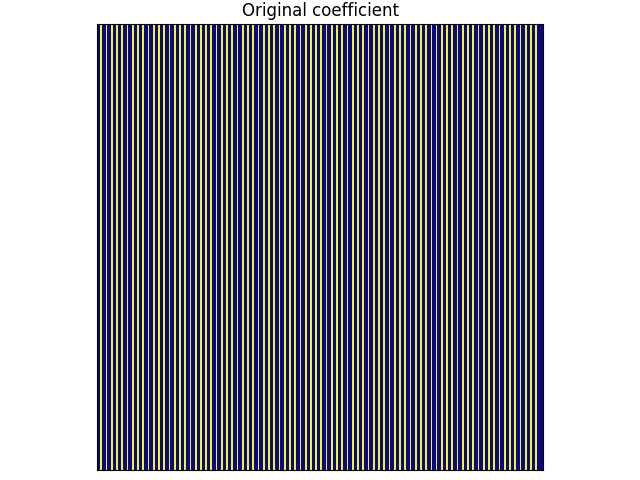

_____________ 1% Perturbations __________
_____Sample__ 1/100 ____
Not Recomputed!
Affected correctors: 80.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 8.0
p = 10% Updated correctors: 26.0
p = 20% Updated correctors: 50.0
p = 30% Updated correctors: 77.0
p = 100% Updated correctors: 80.0
_____Sample__ 2/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 3/100 ____
Not Recomputed!
Affected correctors: 96.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 22.0
p = 20% Updated correctors: 50.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 96.0
_____Sample__ 4/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing t

p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 34/100 ____
Not Recomputed!
Affected correctors: 96.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 22.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 96.0
_____Sample__ 35/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 36/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 37/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing t

p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 68/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 69/100 ____
Not Recomputed!
Affected correctors: 144.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 15.0
p = 10% Updated correctors: 22.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 79.0
p = 100% Updated correctors: 144.0
_____Sample__ 70/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 71/100 ____
Not Recomputed!
Affected correctors: 96.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 22.0
p = 20% Updated correctors: 52.0
p = 30% Update

p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____________ 2% Perturbations __________
_____Sample__ 1/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 2/100 ____
Not Recomputed!
Affected correctors: 256.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 12.0
p = 10% Updated correctors: 24.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 77.0
p = 100% Updated correctors: 256.0
_____Sample__ 3/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 4/100 ____
Not Recomputed!
Affected correctors: 192.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 24.0
p = 20% 

Not Recomputed!
Affected correctors: 112.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 28.0
p = 20% Updated correctors: 50.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 112.0
_____Sample__ 34/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 35/100 ____
Not Recomputed!
Affected correctors: 192.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 24.0
p = 20% Updated correctors: 50.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 192.0
_____Sample__ 36/100 ____
Not Recomputed!
Affected correctors: 112.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 28.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 112.0
_____S

p = 10% Updated correctors: 24.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 192.0
_____Sample__ 66/100 ____
Not Recomputed!
Affected correctors: 0.0
p = 0% nothing to update
p = 5% nothing to update
p = 10% nothing to update
p = 20% nothing to update
p = 30% nothing to update
p = 100% nothing to update
_____Sample__ 67/100 ____
Not Recomputed!
Affected correctors: 256.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 13.0
p = 10% Updated correctors: 26.0
p = 20% Updated correctors: 50.0
p = 30% Updated correctors: 77.0
p = 100% Updated correctors: 256.0
_____Sample__ 68/100 ____
Not Recomputed!
Affected correctors: 144.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 15.0
p = 10% Updated correctors: 27.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 79.0
p = 100% Updated correctors: 144.0
_____Sample__ 69/100 ____
Not Recomputed!
Affected correctors: 240.0
p = 0% Updated correctors: 0.0
p = 5% Updat

p = 100% Updated correctors: 256.0
_____Sample__ 98/100 ____
Not Recomputed!
Affected correctors: 224.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 24.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 224.0
_____Sample__ 99/100 ____
Not Recomputed!
Affected correctors: 208.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 26.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 208.0
_____Sample__ 100/100 ____
Not Recomputed!
Affected correctors: 208.0
p = 0% Updated correctors: 0.0
p = 5% Updated correctors: 14.0
p = 10% Updated correctors: 22.0
p = 20% Updated correctors: 52.0
p = 30% Updated correctors: 78.0
p = 100% Updated correctors: 208.0


In [4]:
#background
bg = 0.05
#values
val = 1
random.seed(20)
#fine World
NWorldFine = np.array([256, 256])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([16,16])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#coefficient 2
CoefClass = buildcoef2d.Coefficient2d(NWorldFine, 
                        bg                  = bg,
                        val                 = val,
                        length              = 1,
                        thick               = 1,
                        space               = 2,
                        probfactor          = 1,
                        right               = 0,
                        down                = 0,
                        diagr1              = 0,
                        diagr2              = 0,
                        diagl1              = 0,
                        diagl2              = 0,
                        LenSwitch           = None,
                        thickSwitch         = None,
                        equidistant         = True,
                        ChannelHorizontal   = None,
                        ChannelVertical     = True,
                        BoundarySpace       = True)


A = CoefClass.BuildCoefficient()
ABase = A.flatten()
        
plt.figure("OriginalCoefficient")
drawCoefficient(NWorldFine, ABase)
plt.title('Original coefficient')

k = 4

###### precompute #######
NWorldFine = world.NWorldFine
NWorldCoarse = world.NWorldCoarse
NCoarseElement = world.NCoarseElement

boundaryConditions = world.boundaryConditions
NpFine = np.prod(NWorldFine+1)
NpCoarse = np.prod(NWorldCoarse+1)

#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#old Coefficient (need flatten form)
ABase = A.flatten()
Aold = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

pglod = pg_rand.VcPetrovGalerkinLOD(Aold, world, k, IPatchGenerator, 0)
pglod.originCorrectors(clearFineQuantities=False)

#Perturbations
print '_____________ 1% Perturbations __________'
prob = 100

MC = 100
a, mum = result(pglod, world, CoefClass, A, f, MC, prob)

#Perturbations
print '_____________ 2% Perturbations __________'
prob = 50

MC = 100
a, mum = result(pglod, world, CoefClass, A, f, MC, prob)